In [3]:
import pandas as pd

data = pd.read_csv('../ssd_data/lstm_data/final_data_MA1.csv',index_col=False)

# 데이터를 시간 순서대로 정렬 ('ds' 컬럼을 기준으로)
data = data.sort_values(by=['ds'])
data = data.drop_duplicates(subset=['disk_id', 'ds'])
data.reset_index(inplace=True)
del(data['index'])
data

,disk_id,ds,r_1,n_5,r_5,r_9,r_12,n_171,r_171,n_172,...,r_194,r_195,n_196,r_196,r_197,r_198,r_199,n_175,r_175,label
0,28267,2019-01-01,4.294967e+09,95.0,0.0,46339.0,41.0,100.0,0.0,100.0,...,14.0,2.202509e+08,100.0,0.0,0.0,0.0,0.0,100.0,1.159917e+12,0
1,1674,2019-01-01,4.294967e+09,96.0,0.0,9021.0,-1.0,-1.0,-1.0,-1.0,...,14.0,-1.000000e+00,100.0,0.0,-1.0,-1.0,-1.0,100.0,2.323887e+11,0
2,3160,2019-01-01,4.294967e+09,98.0,0.0,40273.0,29.0,100.0,0.0,100.0,...,13.0,1.100210e+06,100.0,0.0,0.0,0.0,0.0,100.0,1.027004e+12,0
3,11918,2019-01-01,4.294967e+09,97.0,0.0,38090.0,-1.0,-1.0,-1.0,-1.0,...,12.0,-1.000000e+00,100.0,0.0,-1.0,-1.0,-1.0,100.0,9.582576e+11,0
4,12036,2019-01-01,4.294967e+09,97.0,1.0,38317.0,-1.0,-1.0,-1.0,-1.0,...,19.0,-1.000000e+00,99.0,1.0,-1.0,-1.0,-1.0,100.0,9.664309e+11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75164,1664,2019-06-30,4.294967e+09,97.0,0.0,23299.0,-1.0,-1.0,-1.0,-1.0,...,15.0,-1.000000e+00,100.0,0.0,-1.0,-1.0,-1.0,100.0,5.970077e+11,0
75165,10533,2019-06-30,4.294967e+09,94.0,0.0,50860.0,33.0,100.0,0.0,100.0,...,15.0,1.333815e+09,100.0,0.0,0.0,0.0,0.0,100.0,1.288904e+12,0
75166,13332,2019-06-30,4.294967e+09,97.0,0.0,42594.0,-1.0,-1.0,-1.0,-1.0,...,15.0,-1.000000e+00,100.0,0.0,-1.0,-1.0,-1.0,100.0,1.082661e+12,0
75167,6924,2019-06-30,4.294967e+09,94.0,0.0,50024.0,43.0,100.0,0.0,100.0,...,15.0,8.036993e+08,100.0,0.0,0.0,0.0,0.0,100.0,1.258629e+12,0


In [62]:
# 70% 지점의 인덱스를 찾아 훈련 및 테스트 데이터로 분할
index_70_percent = int(len(data) * 0.7)
cutoff_date = data.iloc[index_70_percent]['ds']

data = data.sort_values(by=['ds'])

# cutoff_date 이전의 데이터는 train_data로, 이후 데이터는 test_data로 분할
train_data = data[data['ds'] <= cutoff_date]
train_data['ds']=pd.to_datetime(train_data['ds'])

test_data = data[data['ds'] > cutoff_date]
test_data['ds']=pd.to_datetime(test_data['ds'])

X_train = train_data.drop(['label'],axis=1)
y_train = train_data[['disk_id', 'ds', 'label']]
X_test = test_data.drop(['ds','label'],axis=1)
y_test = test_data[['disk_id','ds','label']]

C:\Users\choib\AppData\Local\Temp\ipykernel_15156\1291999633.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['ds']=pd.to_datetime(train_data['ds'])
C:\Users\choib\AppData\Local\Temp\ipykernel_15156\1291999633.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['ds']=pd.to_datetime(test_data['ds'])


In [217]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(28, 256, batch_first=True)
        self.fc1 = nn.Linear(256, 128)
        #self.relu = nn.ReLU()
        #self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        _, (x, _) = self.lstm1(x)
        x = self.fc1(x.squeeze(1))
        #x = self.relu(x)
        #x = self.dropout1(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# 모델 인스턴스 생성
lstm_model = LSTMModel()


In [4]:
filled_data = pd.DataFrame()

unique_ids = data['disk_id'].unique()

for disk_id in unique_ids:
    disk_data = data[data['disk_id'] == disk_id].copy()
    # disk_data를 날짜별로 정렬
    disk_data['ds'] = pd.to_datetime(disk_data['ds'])
    disk_data = disk_data.sort_values(by='ds')

    # 인덱스를 날짜로 설정
    disk_data = disk_data.set_index('ds', drop=True)

    # 비어있는 날짜를 ffill 방법으로 채우기
    all_dates = pd.date_range(start=disk_data.index.min(), end=disk_data.index.max(), freq='D')
    disk_data = disk_data.reindex(all_dates, method='pad')

    filled_data=pd.concat([filled_data,disk_data])

In [5]:
filled_data

,disk_id,r_1,n_5,r_5,r_9,r_12,n_171,r_171,n_172,r_172,...,r_194,r_195,n_196,r_196,r_197,r_198,r_199,n_175,r_175,label
2019-01-01,28267,4.294967e+09,95.0,0.0,46339.0,41.0,100.0,0.0,100.0,0.0,...,14.0,220250874.0,100.0,0.0,0.0,0.0,0.0,100.0,1.159917e+12,0
2019-01-02,28267,4.294967e+09,95.0,0.0,46363.0,41.0,100.0,0.0,100.0,0.0,...,15.0,220259327.0,100.0,0.0,0.0,0.0,0.0,100.0,1.160011e+12,0
2019-01-03,28267,4.294967e+09,95.0,0.0,46387.0,41.0,100.0,0.0,100.0,0.0,...,14.0,220267845.0,100.0,0.0,0.0,0.0,0.0,100.0,1.160105e+12,0
2019-01-04,28267,4.294967e+09,95.0,0.0,46410.0,41.0,100.0,0.0,100.0,0.0,...,15.0,220276091.0,100.0,0.0,0.0,0.0,0.0,100.0,1.160199e+12,0
2019-01-05,28267,4.294967e+09,95.0,0.0,46434.0,41.0,100.0,0.0,100.0,0.0,...,15.0,220284244.0,100.0,0.0,0.0,0.0,0.0,100.0,1.160293e+12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-26,8833,3.003738e+09,98.0,0.0,35324.0,47.0,100.0,0.0,100.0,0.0,...,17.0,706984162.0,100.0,0.0,0.0,0.0,0.0,100.0,8.891083e+11,0
2019-06-27,8833,3.012910e+09,98.0,0.0,35348.0,47.0,100.0,0.0,100.0,0.0,...,17.0,707001751.0,100.0,0.0,0.0,0.0,0.0,100.0,8.892022e+11,0
2019-06-28,8833,3.021525e+09,98.0,0.0,35371.0,47.0,100.0,0.0,100.0,0.0,...,17.0,707019218.0,100.0,0.0,0.0,0.0,0.0,100.0,8.892961e+11,0
2019-06-29,8833,3.029780e+09,98.0,0.0,35395.0,47.0,100.0,0.0,100.0,0.0,...,17.0,707033018.0,100.0,0.0,0.0,0.0,0.0,100.0,8.893900e+11,0


In [191]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, filled_data):
        self.filled_data = filled_data
        self.disk_ids = filled_data['disk_id'].unique()
        
        # 각 disk_id별로 데이터를 미리 준비
        self.samples = []
        self.labels = []
        for disk_id in self.disk_ids:
            disk_data = filled_data[filled_data['disk_id'] == disk_id]
            
            # 5일 윈도우로 데이터 나누기
            for i in range(len(disk_data) - 4):
                sequence = disk_data.iloc[i:i+5].drop(columns=['disk_id', 'label']).values
                label = disk_data.iloc[i + 4]['label']
                self.samples.append(sequence)
                self.labels.append(label)
                
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        return torch.tensor(self.samples[index], dtype=torch.float32), torch.tensor(self.labels[index], dtype=torch.float32)

# 사용 예시:
# filled_data 라는 데이터프레임이 있다고 가정
# filled_data = pd.read_csv('path_to_your_filled_data.csv')

# CustomDataset 인스턴스 생성
dataset = CustomDataset(filled_data)

# 인덱스를 사용하여 데이터 얻기
input_data, label = dataset[0]

In [194]:
from torch.utils.data import DataLoader
# 데이터로더 설정
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [212]:
import torch
import torch.nn as nn


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# 손실 함수와 최적화 알고리즘 설정
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

# 훈련 설정
num_epochs = 10

# 훈련 루프
for epoch in range(num_epochs):
    total_loss = 0.0

    for inputs, targets in dataloader:
        # 입력 데이터와 타겟 데이터를 GPU로 이동
        inputs = inputs.to(device)
        targets = targets.to(device)

        # 그래디언트 초기화
        optimizer.zero_grad()

        # 순방향 전파
        outputs = lstm_model(inputs)

        # LSTM 모델의 출력 크기를 target과 일치시키기 위해 필요한 부분만 사용
        # 마지막 시간 단계의 출력만 사용합니다.
        outputs = outputs.squeeze()

        # 손실 계산
        loss = criterion(outputs, targets.float())

        # 역전파 및 가중치 업데이트
        loss.backward()
        optimizer.step()

        # 손실 누적
        total_loss += loss.item()

    # 에폭마다 손실 출력
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss}")

# 훈련 종료 후 모델 저장
torch.save(lstm_model.state_dict(), 'lstm_model.pth')

Epoch 1/10, Loss: 1322.6326724682003
Epoch 2/10, Loss: 1315.6132441684604
Epoch 3/10, Loss: 1308.8682391792536
Epoch 4/10, Loss: 1305.7503788545728
Epoch 5/10, Loss: 1303.5874509438872
Epoch 6/10, Loss: 1301.6289799585938
Epoch 7/10, Loss: 1300.449726190418
Epoch 8/10, Loss: 1299.4021066389978
Epoch 9/10, Loss: 1299.5530086755753
Epoch 10/10, Loss: 1299.221768911928


In [218]:
import torch
import torch.nn as nn


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# 손실 함수와 최적화 알고리즘 설정
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

# 훈련 설정
num_epochs = 5

# 훈련 루프
for epoch in range(num_epochs):
    total_loss = 0.0

    for inputs, targets in dataloader:
        # 입력 데이터와 타겟 데이터를 GPU로 이동
        inputs = inputs.to(device)
        targets = targets.to(device)

        # 그래디언트 초기화
        optimizer.zero_grad()

        # 순방향 전파
        outputs = lstm_model(inputs)

        # LSTM 모델의 출력 크기를 target과 일치시키기 위해 필요한 부분만 사용
        # 마지막 시간 단계의 출력만 사용합니다.
        outputs = outputs.squeeze()

        # 손실 계산
        loss = criterion(outputs, targets.float())

        # 역전파 및 가중치 업데이트
        loss.backward()
        optimizer.step()

        # 손실 누적
        total_loss += loss.item()

    # 에폭마다 손실 출력
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss}")

# 훈련 종료 후 모델 저장
torch.save(lstm_model.state_dict(), 'lstm_model.pth')

Epoch 1/5, Loss: 1315.841678140685
Epoch 2/5, Loss: 1308.2197451852262
Epoch 3/5, Loss: 1306.8757094796747
Epoch 4/5, Loss: 1306.212860705331
Epoch 5/5, Loss: 1305.1067350618541


In [220]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터로더 설정
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 손실 함수와 최적화 알고리즘 설정
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

# 훈련 설정
num_epochs = 2

# 훈련 루프
for epoch in range(num_epochs):
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, targets in dataloader:
        # 입력 데이터와 타겟 데이터를 GPU로 이동
        inputs = inputs.to(device)
        targets = targets.to(device)

        # 그래디언트 초기화
        optimizer.zero_grad()

        # 순방향 전파
        outputs = lstm_model(inputs)
        outputs = outputs.squeeze()

        # 손실 계산
        loss = criterion(outputs, targets.float())

        # 역전파 및 가중치 업데이트
        loss.backward()
        optimizer.step()

        # 손실 누적
        total_loss += loss.item()

        # 정확도 계산
        predictions = (outputs > 0.5).float()
        correct_predictions += (predictions == targets).float().sum().item()
        total_predictions += targets.size(0)

    # 에폭마다 손실과 정확도 출력
    accuracy = 100 * correct_predictions / total_predictions
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss}, Accuracy: {accuracy:.2f}%")

# 훈련 종료 후 모델 저장
torch.save(lstm_model.state_dict(), 'lstm_model.pth')


Epoch 1/2, Loss: 1305.448618490249, Accuracy: 93.48%
Epoch 2/2, Loss: 1304.8488254901022, Accuracy: 93.48%


## Tensorflow

In [1]:
import numpy as np
def create_sequences(data, window_size):
    X = []
    y = []

    # 각 disk_id에 대해 처리
    for disk_id in data['disk_id'].unique():
        disk_data = data[data['disk_id'] == disk_id].sort_values('ds')  # ds로 정렬
        disk_values = disk_data.drop(columns=['disk_id', 'ds']).values  # 'disk_id'와 'ds' 컬럼을 제외하고 numpy array로 변환

        # 이 disk_id에 대해 시퀀스 생성
        for i in range(len(disk_values) - window_size):
            X.append(disk_values[i:i + window_size, :-1])  # 마지막 차원은 특성(feature)을 의미합니다. 마지막 열('fail')을 제외합니다.
            y.append(disk_values[i + window_size, -1])  # 예를 들어 'fail' 상태가 마지막 특성일 경우입니다.

    return np.array(X), np.array(y)

In [6]:
# 70% 지점의 인덱스를 찾아 훈련 및 테스트 데이터로 분할
index_70_percent = int(len(data) * 0.7)
cutoff_date = data.iloc[index_70_percent]['ds']

# cutoff_date 이전의 데이터는 train_data로, 이후 데이터는 test_data로 분할
train_data = data[data['ds'] <= cutoff_date]
test_data = data[data['ds'] > cutoff_date]


X_train = train_data.drop(['disk_id','ds','label'],axis=1)
y_train = train_data['label']
X_test = test_data.drop(['disk_id','ds','label'],axis=1)
y_test = test_data['label']
X_train

,r_1,n_5,r_5,r_9,r_12,n_171,r_171,n_172,r_172,n_173,...,r_190,r_194,r_195,n_196,r_196,r_197,r_198,r_199,n_175,r_175
0,4.294967e+09,95.0,0.0,46339.0,41.0,100.0,0.0,100.0,0.0,52.0,...,14.0,14.0,220250874.0,100.0,0.0,0.0,0.0,0.0,100.0,1.159917e+12
1,4.294967e+09,96.0,0.0,9021.0,-1.0,-1.0,-1.0,-1.0,-1.0,47.0,...,-1.0,14.0,-1.0,100.0,0.0,-1.0,-1.0,-1.0,100.0,2.323887e+11
2,4.294967e+09,98.0,0.0,40273.0,29.0,100.0,0.0,100.0,0.0,97.0,...,13.0,13.0,1100210.0,100.0,0.0,0.0,0.0,0.0,100.0,1.027004e+12
3,4.294967e+09,97.0,0.0,38090.0,-1.0,-1.0,-1.0,-1.0,-1.0,97.0,...,-1.0,12.0,-1.0,100.0,0.0,-1.0,-1.0,-1.0,100.0,9.582576e+11
4,4.294967e+09,97.0,1.0,38317.0,-1.0,-1.0,-1.0,-1.0,-1.0,17.0,...,-1.0,19.0,-1.0,99.0,1.0,-1.0,-1.0,-1.0,100.0,9.664309e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52681,4.294967e+09,96.0,0.0,40673.0,-1.0,-1.0,-1.0,-1.0,-1.0,70.0,...,-1.0,14.0,-1.0,100.0,0.0,-1.0,-1.0,-1.0,100.0,1.027116e+12
52682,4.294967e+09,98.0,2.0,43092.0,28.0,100.0,2.0,100.0,0.0,1.0,...,20.0,20.0,297294512.0,99.0,2.0,0.0,0.0,0.0,100.0,1.095782e+12
52683,4.294967e+09,92.0,0.0,48777.0,25.0,100.0,0.0,100.0,0.0,85.0,...,16.0,16.0,223080006.0,100.0,0.0,0.0,0.0,0.0,100.0,1.241408e+12
52684,4.294967e+09,96.0,0.0,43904.0,29.0,100.0,0.0,100.0,0.0,68.0,...,19.0,19.0,929475655.0,100.0,0.0,0.0,0.0,0.0,100.0,1.112414e+12


In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [8]:
# Assuming 'X_train' is the original DataFrame before scaling and its columns are to be preserved
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

train_scaled = pd.concat([train_data[['disk_id','ds']],X_train_scaled_df, y_train], axis=1)
test_scaled = pd.concat([test_data[['disk_id','ds']],X_test_scaled_df, y_test], axis=1)

In [9]:
window_size = 3 # 10일을 window로 설정합니다.
X_train_window, y_trian_window = create_sequences(train_scaled, window_size)
X_test_window, y_test_window = create_sequences(test_scaled, window_size)

In [10]:
# 라이브러리 임포트
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras import regularizers

# LSTM 모델 정의
model = Sequential()
model.add(LSTM(16, activation='relu', input_shape=(3, 28)))  # n_features는 특성의 수
model.add(Dense(16, kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['acc'])

# 학습
history = model.fit(X_train_window,y_trian_window,epochs=4, verbose=0,batch_size=32)

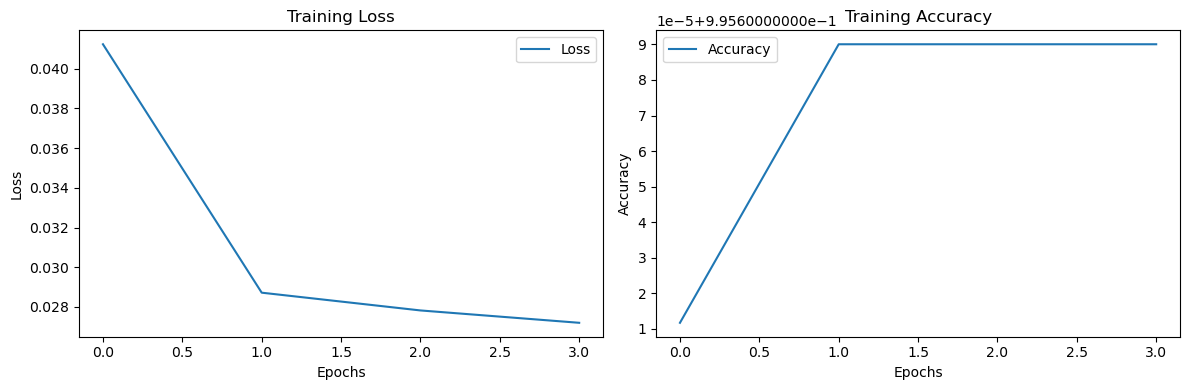

In [11]:
import matplotlib.pyplot as plt

# 훈련 손실과 정확도 그리기
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['acc'], label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
model.evaluate(X_test_window,y_test_window)

659/659 [==============================] - 1s 1ms/step - loss: 0.0139 - acc: 0.9984


[0.013941628858447075, 0.998432993888855]

In [13]:
from sklearn.metrics import f1_score

# 테스트 데이터셋을 사용하여 예측 수행
y_pred = model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.
y_pred = np.round(y_pred) # 이진 분류 문제의 경우, 출력값을 반올림하여 0 또는 1로 변환

# f1 score 계산
f1 = f1_score(y_test_window, y_pred, average='macro') # y_test_window는 테스트 데이터셋의 실제 레이블이어야 합니다.

print(f'F1 Score: {f1}')

659/659 [==============================] - 1s 940us/step
F1 Score: 0.4996079363193537


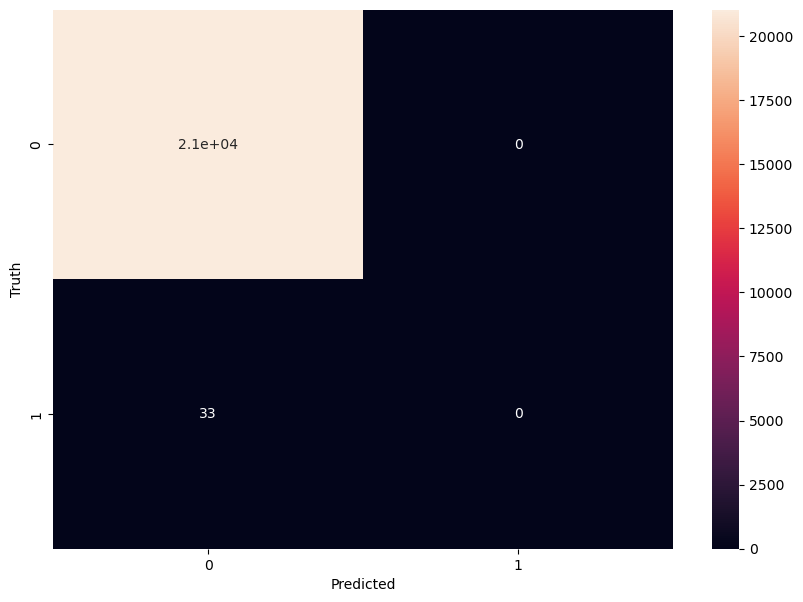

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_window, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()